In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

from eofs.xarray import Eof
from eofs.examples import example_data_path

In [2]:
#function which defines the models used for each experiment.
def get_models_for_experiment(experiment):
    if experiment == 'historical':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-aer':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#'CNRM-CM6-1' to be added once CVDP EM calc
    elif experiment == 'hist-GHG':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#'CNRM-CM6-1' to be added once CVDP EM calc
    elif experiment == 'hist-sol':
        model = ['ACCESS-ESM1-5','CanESM5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-totalO3':
        model = ['CanESM5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-volc':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']

    return model
    
def CVDP_EM_crop_NA_sector(filename, pattern):
    #function which will crop the historical ensemble mean CVDP output to the NA sector
    ds = xr.open_dataset(filename)
    ds = ds[pattern]
    
    #finding the longitudes that are greater than 180
    new_lon = np.where(ds.lon > 179, ds.lon -360, ds.lon)
    
    #creating a copy of the data array where the longitudes have been shifted
    ds_shifted = ds.copy()
    ds_shifted.coords['lon'] = new_lon
    
    #Now need to make sure they are in the correct order and then re-index to make sure the lon get put to match the sorted lon
    sorted_lon = np.sort(ds_shifted.lon)
    ds_shifted = ds_shifted.sel(lon=sorted_lon)
    
    historical_NAO_EM_shifted = ds_shifted.sel(lat=slice(20,80), lon=slice(-90,40))

    return historical_NAO_EM_shifted

def open_cropNA_unitshPA(filename):
    #function to crop an ensemble member to the north atlantic region
    data = xr.open_dataset(filename)
    data_NA = data.sel(lat=slice(20,80), lon=slice(-90,40))/100

    return data_NA

In [3]:
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_regression_map.nc')
ds

<xarray.Dataset> Size: 11kB
Dimensions:             (lat: 25, lon: 53)
Coordinates:
  * lat                 (lat) float64 200B 20.0 22.5 25.0 ... 75.0 77.5 80.0
  * lon                 (lon) float64 424B -90.0 -87.5 -85.0 ... 35.0 37.5 40.0
    season              <U3 12B ...
    mode                int64 8B ...
Data variables:
    regression_NAO_djf  (lat, lon) float64 11kB ...

In [4]:
def project_trend_onto_regression_map(anomalies, trend, mode, trend_var, e, m, period):
    #this will project a trend onto the regression map.
    #psl anomalies are linearly regressed onto the PC timeseries (the amount that the EOF's amplitude changes with time)

    #setting up output files paths for the projection and the residual
    output_regression_map = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/'+mode+'/psl_mon_'+e+'_'+m+'_DJF_'+mode+'_regression_map_'+period+'.nc'


    #selecting the mode of which EOF to calculate
    if mode == 'NAO':
        mode_number = 0
    elif mode == 'EA':
        mode_number = 1

    #opening up all anomaly files and cropping to NA and converting into hPa (anomaly data is in Pa)
    anomaly_list = [open_cropNA_unitshPA(f) for f in anomalies]

    #selecting the psl data and concatenating list of data arrays.
    all_anomalies = xr.concat(anomaly_list, dim='ensemble')['psl']  # Shape: (ensemble, time, lat, lon)
    print(all_anomalies.dims)
        
    #Flatten ensemble and year into one time dimension (needs to be called time for the pcs function to work later)
    all_anomalies_stacked = all_anomalies.stack(time=('ensemble', 'year'))
    all_anomalies_stacked = all_anomalies_stacked.reset_index('time', drop=True)
    all_anomalies_stacked = all_anomalies_stacked.transpose('time', 'lat', 'lon')

    #basically weighting so that each grid cell has influence actually proportional to its area
    coslat = np.cos(np.deg2rad(all_anomalies_stacked.coords['lat'].values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]

    #EOF solver
    solver = Eof(all_anomalies_stacked, weights=wgts)
    
    #finding the pattern of the EOF - unitless
    EOF_pattern = solver.eofs(neofs=mode_number+1).sel(mode=mode_number)
        
    #getting the EA Pattern's PC
    #using pcscaling=1 for a normalised PC. If not normalised need to divide by the variance of PC ((pc.std(dim='time'))**2) to find the regression map.
    pc = solver.pcs(npcs=mode_number+1, pcscaling=1).sel(mode=mode_number)
        
    #finding regression_map = pattern of psl anomalies regressed onto EA PC, kinda which bits of the trend link to this pattern, units of hPa/unit of PC
    #how psl anomalies change spatially for a one-unit change in the PC
    regression_map = (all_anomalies_stacked * pc).mean(dim='time')

    #making sure that the patterns match what they should for the NAO and EA patterns (basically fixing for sign conventions to make sure physical)
    if mode == 'NAO' and regression_map.sel(lat=50, lon=-30, method='nearest') < 0:
        regression_map *= -1
        pc *= -1

    if mode == 'NAO' and regression_map.sel(lat=50, lon=-25, method='nearest') > 0:
        regression_map *= -1
        pc *= -1
        
    #outputting .nc files for plotting

    
    regression_map.name = 'regression_'+mode+'_djf'
    regression_map.to_netcdf(output_regression_map)
    
    return regression_map, EOF_pattern

In [5]:
def project_onto_regression(trend_raw, regression_map, trend_var, mode, e, m, period):
    #function which will project a trend (lat,lon) in hPa onto a spatial pattern (lat,lon) hPa to get a single NAO index value
    #will then calculate the residual (trend - mode_congruent part) and saves both the NAO congruent part and the residual
    #in the same folder, output_file is for the NAO/EA_congruent part filename
    #can then change the input spat pattern to calculate the projection onto other eofs, e.g. the EAP


    if isinstance(trend_raw, xr.DataArray):
        trend = trend_raw
    else:
        print('here')
        trend = trend_raw[trend_var]
        
    # Weight psl data by coslat to account for grid cell area decreasing with latitude
    weights = np.cos(np.radians(trend["lat"].values))
    weights_2d = weights[:, np.newaxis]

    # weight psl (or another variable) anomalies by area of each gridcell
    weighted_trend = trend * weights_2d
    weighted_regression = regression_map * weights_2d

    # flatten both of the fields so that they are both 1D
    trend_flat = weighted_trend.stack(spatial=('lat','lon'))
    regression_flat = weighted_regression.stack(spatial=('lat','lon'))

    #replace any NaNs with zeros to stop any weird stuff happening
    trend_flat = trend_flat.fillna(0)
    regression_flat = regression_flat.fillna(0)

    #Now do the dot product which is the projection
    dot_product = (trend_flat * regression_flat).sum().item()

    #calculating the index - or I guess the PC?????
    index = dot_product / (regression_flat**2).sum().item()

    #Now multiplying the pattern by the index and returning that too
    projection = index * regression_map
    residual = trend - projection
    
    projection.name = 'projection_'+mode+'_djf'
    residual.name = 'residual_'+mode+'_djf'

    output_projection = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_'+mode+'_projection_'+period+'.nc'
    output_residual = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_'+mode+'_residual_'+period+'.nc'
    
    #outputting .nc files for plotting
    projection.to_netcdf(output_projection)
    residual.to_netcdf(output_residual)
    
    return projection, residual

In [34]:
#residual_trend = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO_forced_trends/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_residual.nc')
period = '1850-2015'
trend_filename = '/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_linear_trend_'+period+'.nc'
trend = open_cropNA_unitshPA(trend_filename) * 165 #converts from Pa/year to hPa (the function converts from Pa to hPa so need to multiply by 165 for the hPa not hPa/year)

experiment = ['historical']
model = ['HadGEM3-GC31-LL']


for e in experiment:
    for m in model:

        #path to the folder containing each experiment and model's psl anomalies
        folder_path = f'/gws/nopw/j04/extant/users/slbennie/psl_anomalies/{e}/{m}/'

        #creating the list of files for this experiment and model's psl anomalies
        ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and '_EM' not in filename]

        regression_map_NAO, EOF_pattern_NAO = project_trend_onto_regression_map(ens_files, trend, 'NAO', 'slope', e, m, period)
        regression_map_EA, EOF_pattern_EA = project_trend_onto_regression_map(ens_files, trend, 'EA', 'slope', e, m, period)


('ensemble', 'year', 'lat', 'lon')
('ensemble', 'year', 'lat', 'lon')


In [7]:
#setting up variables
period = '1950-2015'
variable = 'slope'
modes = ['NAO', 'EA']
#probably a smart way to just open this file only once???
model = ['HadGEM3-GC31-LL']

#list of experiments
experiment = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']
    
for m in model:
    print('Model:', m)
    regression_NAO = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/psl_mon_historical_'+m+'_DJF_NAO_regression_map_1850-2015.nc')
    regression_EA = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/psl_mon_historical_'+m+'_DJF_EA_regression_map_1850-2015.nc')

    for e in experiment:
        print("Calculating the projection of the forced trend onto historical regression map calculated from all ensembles:", e)
        
        #now setting up the folder path to get the file names for each experiment's model's forced trend
        folder_path = '/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'
            
        #Getting the list of file names within the models folder, should only be one trend per model (working off the ensemble means for each model)
        ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and period in filename]
            
        for i in range(0,len(ens_files)):
            #cropping each trend to just the NA sector and whichever time
            trend = open_cropNA_unitshPA(ens_files[i])#, 1850,2014)
    
            #multiplying the trend by 165 to convert to units of hPa (currently in units of hPa/year, trend calculated between 1850-2015)
            trend = trend * 165

            #remember variable might change depending on how you save the files then open and pass through function or just pass through the saved residual

            proj_NAO, residual_NAO = project_onto_regression(trend, regression_NAO['regression_NAO_djf'], variable, 'NAO', e, m, period)
            proj_EA, residual_EA = project_onto_regression(residual_NAO, regression_EA['regression_EA_djf'], variable, 'EA', e, m, period)

#print(residual_NAO, residual_EA)

Model: HadGEM3-GC31-LL
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: historical
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-aer
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-GHG
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-sol
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-totalO3
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-volc
here


/tmp/ipykernel_567/3224287222.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


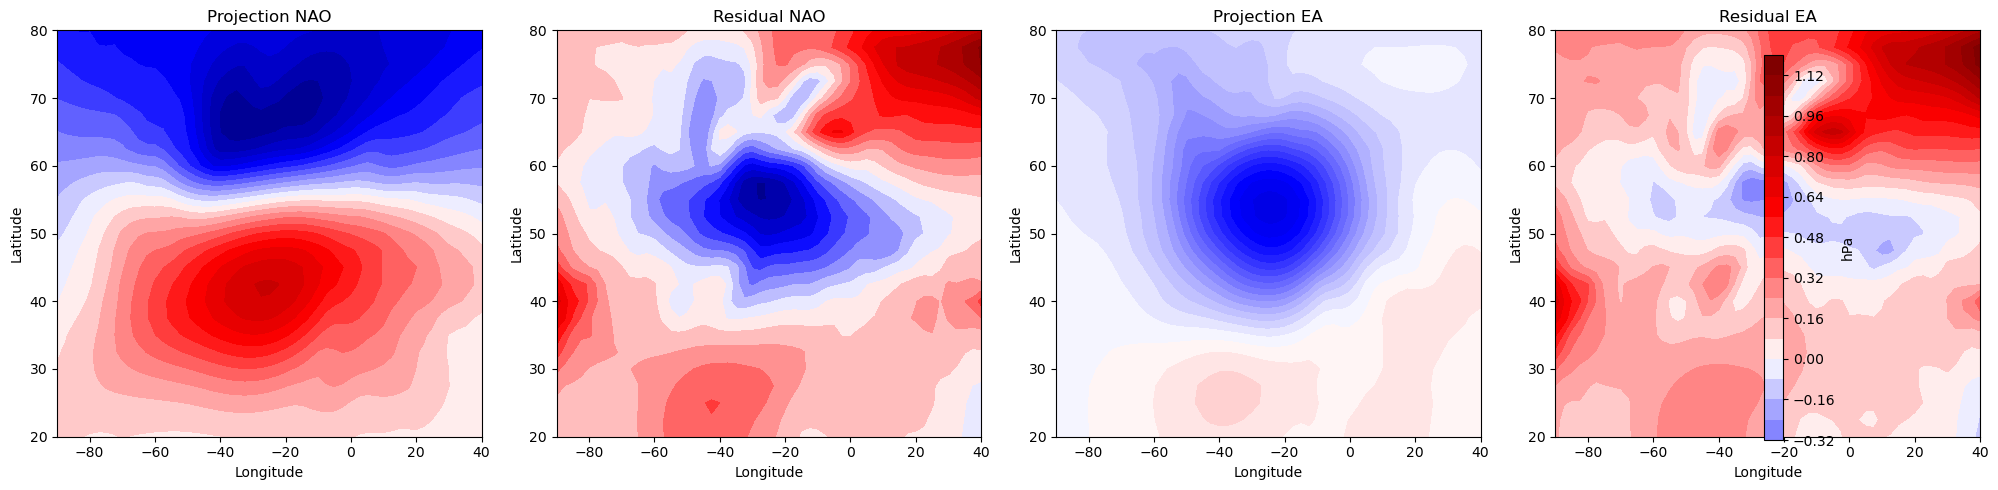

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming proj_NAO, residual_NAO, proj_EA, residual_EA are xarray DataArrays

# Find the global min and max for consistent color scale, symmetric around zero
all_data = np.concatenate([
    proj_NAO.values.flatten(),
    residual_NAO.values.flatten(),
    proj_EA.values.flatten(),
    residual_EA.values.flatten()
])

vmax = np.nanmax(np.abs(all_data))
vmin = -vmax  # symmetric about zero

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

# Plot with contourf, fixed vmin/vmax, and seismic colormap
cf0 = ax[0].contourf(proj_NAO['lon'], proj_NAO['lat'], proj_NAO, 
                     levels=21, cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_title('Projection NAO')

cf1 = ax[1].contourf(residual_NAO['lon'], residual_NAO['lat'], residual_NAO, 
                     levels=21, cmap='seismic', vmin=vmin, vmax=vmax)
ax[1].set_title('Residual NAO')

cf2 = ax[2].contourf(proj_EA['lon'], proj_EA['lat'], proj_EA, 
                     levels=21, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('Projection EA')

cf3 = ax[3].contourf(residual_EA['lon'], residual_EA['lat'], residual_EA, 
                     levels=21, cmap='seismic', vmin=vmin, vmax=vmax)
ax[3].set_title('Residual EA')

# Add a single colorbar for all plots on the right side
cbar = fig.colorbar(cf3, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('hPa')

# Label axes
for a in ax:
    a.set_xlabel('Longitude')
    a.set_ylabel('Latitude')

plt.tight_layout()
plt.show()


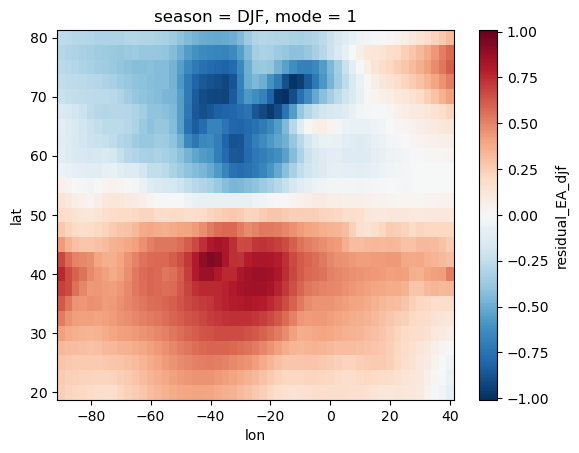

In [90]:
residual_EA.plot()

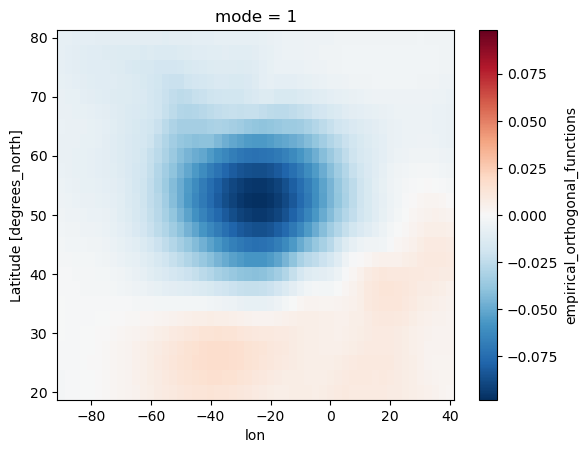

In [8]:
EOF_pattern_EA.plot()